In [1]:
import matplotlib.pyplot as plt
import tools.dataTools as dt
from constants import Constants
import figure_params
import numpy as np
import os
from tools.test import test_model
import pandas as pd
import pyaldata as pyal
import pickle
import scipy
from matplotlib import cm
import warnings
from tqdm.auto import tqdm
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib import cm


figure_params.set_rc_params()
figure_params.setup_directories()

SUBFIG_DIR = Constants.FIG_FOLDER + 'figS8_exp/'
if not os.path.exists(SUBFIG_DIR):
    os.makedirs(SUBFIG_DIR)

#run simulations for figure, will take a while to run
import subprocess
os.chdir(Constants.PROJ_DIR)
# subprocess.run(["bash", "simulation/fig_simulations/Sfig_centerout_sims.sh"]) #uncomment code to make datasets if not made yet

import warnings
warnings.filterwarnings("ignore")

In [2]:
repertoires = Constants.COS
sim_set = 'centerout_rad'
dataset = Constants.SIM_SET_DATA[sim_set]
seeds = Constants.SEEDS
seed_ex = Constants.SEED_EX
pca_dims = 10

#### Get experimental data

In [3]:
subtract_mean = True
exp_data_dir = Constants.PROJ_DIR + Constants.EXP_DATA_FOLDER
fname = os.path.join(exp_data_dir, "Chewie/Chewie_CO_CS_2016-10-21.mat")
exp_df = pyal.mat2dataframe(fname, shift_idx_fields=True)
exp_df = dt.preprocess_exp_data(exp_df, repertoires[0], subtract_mean=subtract_mean)
exp_df = dt.perform_pca(exp_df, pca_dims)
exp_av_per_dir = pyal.trial_average(exp_df, "target_id")

#### Get simulation data

In [4]:
prep_exec_epoch = pyal.generate_epoch_fun(start_point_name='idx_go_cue',
                                    rel_start=int(Constants.WINDOW_prep_exec[0]/Constants.EXP_BIN_SIZE),
                                    rel_end=int(Constants.WINDOW_prep_exec[1]/Constants.EXP_BIN_SIZE)
                                    )
sim_df = dt.model_to_pyaldata(sim_set, seed_ex, 'centerout')
sim_df = pyal.combine_time_bins(sim_df, int(Constants.EXP_BIN_SIZE/Constants.BIN_SIZE))
sim_df = pyal.smooth_signals(sim_df, ["MCx_rates"])
sim_df = pyal.restrict_to_interval(sim_df, epoch_fun = prep_exec_epoch)
if subtract_mean: 
    pyal_df = pyal.subtract_cross_condition_mean(sim_df)
sim_df = dt.perform_pca(sim_df, pca_dims)
sim_av_per_dir = pyal.trial_average(sim_df, 'target_param')

#### Motor output

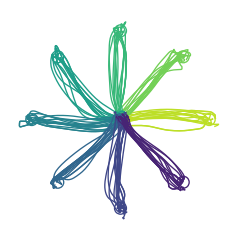

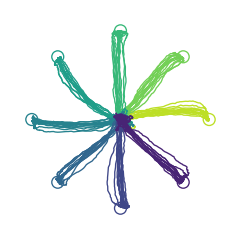

In [5]:
#graph exp reaches
plt.figure()
ax = dt.graph_repertoire(dataset,repertoires[0], graph_all=False)
ax.set_ylim(-10,10)
ax.set_xlim(-10,10)
plt.savefig(SUBFIG_DIR + "target_output.pdf",bbox_inches="tight", format = 'pdf')

#graph simulated reaches
outdir = dt.get_outdir(seed_ex, 'centerout_rad', 'centerout')
datadir,_,output,_ = test_model(outdir)

# get data
datname = Constants.PROJ_DIR + datadir
data = np.load(datname+'.npy',allow_pickle = True).item()['test_set1']    
task_info = np.array(data['target_param'])
moveset = dt.get_moveset('centerout') 

plt.figure()
ax = plt.gca()
dt.graph_position(output, ax, task_info)
ax.set_ylim(-10,10)
ax.set_xlim(-10,10)
plt.savefig(SUBFIG_DIR + "model_output.pdf",bbox_inches="tight", format = 'pdf')


#### Canonical correlation

both_pca:	[0.99103855 0.98183405 0.97485208 0.9476197  0.88584135 0.42071679
 0.22538072 0.05634487 0.01701571 0.00195286]


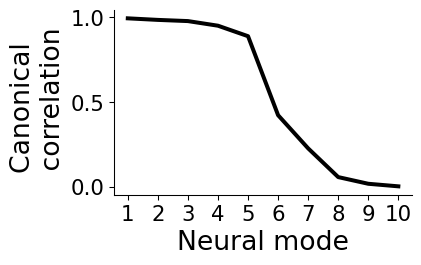

In [6]:
tsteps = exp_av_per_dir.M1_pca.values[0].shape[0]
nrows = len(exp_av_per_dir.index)

plt.figure(figsize = (4,2.5))

signals = ['both_pca'] 

for j, signal in enumerate(signals):
    X = pyal.concat_trials(exp_av_per_dir, signal)
    Y = pyal.concat_trials(sim_av_per_dir, signal)
    A,B,r,U,V = dt.canoncorr(X, Y, fullReturn = True)
    
    CCA_signal = signal.replace('pca', '') + 'CCA'
    exp_av_per_dir[CCA_signal] = [U[i*tsteps:(i+1)*tsteps,] for i in range(nrows)]
    sim_av_per_dir[CCA_signal] = [V[i*tsteps:(i+1)*tsteps,] for i in range(nrows)]
    
    #plot canonical correlation scores
    plt.plot(range(1, pca_dims+1), r, label = signal.replace('_pca', ''), linewidth = 3, 
             color = 'black', alpha = 1 - j*0.35)

    print(f"{signal}:\t{r}")

plt.xticks(np.arange(1,11))
plt.ylabel('Canonical \n correlation')
plt.xlabel('Neural mode')
plt.legend().remove()
plt.savefig(SUBFIG_DIR + "CC_all.pdf",bbox_inches="tight", format = 'pdf')


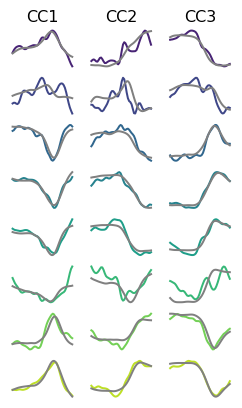

In [7]:
fig, axs = plt.subplots(nrows = 8, ncols = 3, figsize = (3,5))
colors = dt.get_colormap(exp_av_per_dir.target_direction_orig.values, cmap = 'viridis')
orig_targets = exp_av_per_dir.target_direction_orig.values
for i, df_stim in enumerate(exp_av_per_dir['both_CCA']):
    axs[i][0].plot(df_stim[:,0], color = colors[orig_targets[i]])
    axs[i][1].plot(df_stim[:,1], color = colors[orig_targets[i]])
    axs[i][2].plot(df_stim[:,2], color = colors[orig_targets[i]])

for i, df_stim in enumerate(sim_av_per_dir['both_CCA']):
    axs[i][0].plot(df_stim[:,0], color = 'grey')
    axs[i][1].plot(df_stim[:,1], color = 'grey')
    axs[i][2].plot(df_stim[:,2], color = 'grey')

[axi.set_axis_off() for axi in axs.ravel()]

cols = ['CC1', 'CC2', 'CC3']
for ax, col in zip(axs[0], cols):
    ax.set_title(col, size='large')

plt.savefig(SUBFIG_DIR + "CCA_align.pdf",bbox_inches="tight", format = 'pdf')


### Deviation angle

In [8]:
def get_deviation_angle_df(skill_df, pert_df, pert_param, repertoire, sim_set, seed, plot = False, shuffle = False):
    
    #activity during skill learning
    model = pyal.fit_dim_reduce_model(skill_df, PCA(pca_dims), 'MCx_rates')
    skill_df = pyal.apply_dim_reduce_model(skill_df, model, 'MCx_rates', 'both_pca')
    skill_av_df = pyal.trial_average(skill_df, 'target_param')
    skill_av_df = skill_av_df.sort_values(by = 'target_param', ascending=False) #sort movements

    #activity during adaptation
    pert_df = pyal.apply_dim_reduce_model(pert_df, model, 'MCx_rates', 'both_pca')
    pert_av_df = pyal.trial_average(pert_df, 'target_param')
    pert_av_df = pert_av_df.sort_values(by = 'target_param', ascending=False) #sort movements
    pert_param = -pert_param #make CW

    if shuffle:
        rng = Constants.RNG
        pert_av_df = pert_av_df.sample(frac=1) #shuffle targets
        pert_av_df.apply(lambda row: rng.shuffle(row.both_pca), axis = 1) #shuffle time points

    rows_list = []
    for i in range(8): #for each target
        #get latent activity for first two reaches and reach after adaptation
        skill_pca_reach1 = np.array(skill_av_df.both_pca.values.tolist())[i]
        if pert_param > 0: # CCW pert, CW adaptation, target 1 -> target 8
            skill_pca_reach2 = np.array(skill_av_df.both_pca.values.tolist())[(i-1)%8]
        else: # CW pert, CCW adaptation, target 1 -> target 2
            skill_pca_reach2 = np.array(skill_av_df.both_pca.values.tolist())[(i+1)%8]
        pert_pca_reach1 = np.array(pert_av_df.both_pca.values.tolist())[i]

        #get adjacent movement vector
        reach_diff = skill_pca_reach2 - skill_pca_reach1
        reach_diff = np.array([x/np.linalg.norm(x) for x in reach_diff])
        ave_reach_diff = np.mean(reach_diff, axis = 0)

        #get adaptation vector
        pert_diff = pert_pca_reach1 - skill_pca_reach1
        pert_diff = np.array([x/np.linalg.norm(x) for x in pert_diff])
        ave_pert_diff = np.mean(pert_diff, axis = 0)

        #get deviation angle
        ## angle for each time point
        angle = np.degrees(np.arccos(np.clip([np.dot(x, y) for x,y in zip(reach_diff,pert_diff)], -1.0,1.0)))

        temp = {
            'seed': seed,
            'sim_set': sim_set,
            'repertoire': repertoire,
            'ave_reach_vector': ave_reach_diff,
            'ave_pert_vector': ave_pert_diff,
            'angle': angle,
            'target_id': i
        }
        rows_list.append(temp)

    return pd.DataFrame(rows_list)

### Simulation data

#### deviation angle

In [9]:
redo = True
perturbation = 'rotation'
pert_set = 'v1'
pert_param = 30.0
repertoire = 'centerout'
prep_exec_epoch = pyal.generate_epoch_fun(start_point_name='idx_go_cue',
                                        rel_start=int(Constants.WINDOW_prep_exec[0]/Constants.EXP_BIN_SIZE),
                                        rel_end=int(Constants.WINDOW_prep_exec[1]/Constants.EXP_BIN_SIZE)
                                        )

for sim_set in ['centerout_onehot', 'centerout_rad']:
    for shuffle in [True,False]:
        fname = Constants.PROCESSED_DATA_FOLDER + sim_set + '/deviation_angle' + ('_shuffled' if shuffle else '') + '.pickle'
        if redo or (not os.path.isfile(fname)):
            deviation_angles_df = pd.DataFrame({})
            for seed in tqdm(seeds):
                #get activity
                skill_df = dt.model_to_pyaldata(sim_set, seed, repertoire)
                skill_df = pyal.combine_time_bins(skill_df, int(Constants.EXP_BIN_SIZE/Constants.BIN_SIZE))
                skill_df = dt.preprocess_data(skill_df, epoch_fun = prep_exec_epoch, subtract_mean=True)
                pert_df = dt.model_to_pyaldata(sim_set, seed, repertoire, perturbation, pert_param, pert_set)
                pert_df = pyal.combine_time_bins(pert_df, int(Constants.EXP_BIN_SIZE/Constants.BIN_SIZE))
                pert_df = dt.preprocess_data(pert_df, epoch_fun = prep_exec_epoch, subtract_mean=True)
                
                deviation_angles_df_ = get_deviation_angle_df(skill_df, pert_df, pert_param, repertoire, sim_set, seed, shuffle = shuffle)
                deviation_angles_df = pd.concat([deviation_angles_df_,deviation_angles_df])
            with open(fname, 'wb') as f:
                pickle.dump(deviation_angles_df, f)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

#### decay constant

In [10]:
#exponential function
def exp_func(t, A, K, C):
    return A * np.exp(K * t) + C

smooth = True
learn_set = None
perturbation = 'rotation'
pert_param = 30.0
pert_set = 'v1'
repertoire = 'centerout'

reps = Constants.UNIS[1:]

rows_list = []
for seed in seeds:
    for sim_set in ['centerout_onehot', 'centerout_rad']:
        # decay constant
        try:
            loss = dt.get_loss(seed, sim_set, repertoire, perturbation, pert_param, pert_set, smooth = smooth)
            t = np.arange(1,len(loss)+1)
            ## exponential fit
            p0 = (0.1,-0.1,0.2) # starting search koefs
            opt, pcov =  scipy.optimize.curve_fit(exp_func, t, loss, p0)
            A, K, C = opt
            fit_y = exp_func(t, A, K, C)
        except:
            print('failed', seed, sim_set, repertoire)
            decay_constant = None
        error = dt.get_testing_MSE(seed, sim_set, repertoire, perturbation, pert_param, pert_set)

        temp = {
            'seed': seed,
            'sim_set': sim_set,
            'repertoire': repertoire,
            'decay_constant': K,
            'error': error,
        }
        rows_list.append(temp)

sim_decay_df = pd.DataFrame(rows_list)

### Experimental data

In [11]:
# get files
exp_data_dir = Constants.PROJ_DIR + Constants.EXP_DATA_FOLDER
VR_files = []
for monkey in ['Chewie', 'Mihili', 'Chewie2']:
    files = os.listdir(exp_data_dir+monkey)
    files = [(monkey, x) for x in files if (("VR" in x) and (".mat" in x))]

    VR_files.extend(files)
VR_files

[('Chewie', 'Chewie_CO_VR_2016-10-06.mat'),
 ('Chewie', 'Chewie_CO_VR_2016-09-12.mat'),
 ('Chewie', 'Chewie_CO_VR_2016-09-09.mat'),
 ('Chewie', 'Chewie_CO_VR_2016-09-29.mat'),
 ('Chewie', 'Chewie_CO_VR_2016-09-14.mat'),
 ('Mihili', 'Mihili_CO_VR_2015-06-25.mat'),
 ('Mihili', 'Mihili_CO_VR_2014-03-04.mat'),
 ('Mihili', 'Mihili_CO_VR_2015-06-26.mat'),
 ('Mihili', 'Mihili_CO_VR_2015-06-23.mat'),
 ('Mihili', 'Mihili_CO_VR_2014-03-03.mat'),
 ('Mihili', 'Mihili_CO_VR_2014-03-06.mat'),
 ('Chewie2', 'Chewie_CO_VR_2015-07-16.mat'),
 ('Chewie2', 'Chewie_CO_VR_2013-10-03.mat'),
 ('Chewie2', 'Chewie_CO_VR_2015-12-03.mat'),
 ('Chewie2', 'Chewie_CO_VR_2015-12-04.mat'),
 ('Chewie2', 'Chewie_CO_VR_2015-07-10.mat'),
 ('Chewie2', 'Chewie_CO_VR_2013-12-19.mat'),
 ('Chewie2', 'Chewie_CO_VR_2015-07-13.mat'),
 ('Chewie2', 'Chewie_CO_VR_2013-12-20.mat'),
 ('Chewie2', 'Chewie_CO_VR_2015-12-01.mat'),
 ('Chewie2', 'Chewie_CO_VR_2015-07-15.mat'),
 ('Chewie2', 'Chewie_CO_VR_2015-11-19.mat'),
 ('Chewie2', 'Chewie_

#### fit exponential to angle errors

In [12]:
warnings.filterwarnings('ignore')

#exponential function
def exp_func(t, A, K, C):
    return A * np.exp(K * t) + C

rows_list = []
for monkey, file in VR_files[:]:
    print(file)
    fname = os.path.join(exp_data_dir + monkey+ '/'+ file)

    #get and preprocess data
    exp_df = pyal.mat2dataframe(fname, shift_idx_fields=True)

    #collect info before trials are dropped
    ntrials = len(exp_df)
    exp_df['trial_number'] = range(ntrials)
    adapt_start = np.where(exp_df.epoch == 'AD')[0][0]
    adapt_end = np.where(exp_df.epoch == 'WO')[0][0]

    exp_df = pyal.restrict_to_interval(exp_df,'idx_movement_on',rel_start = 0, rel_end = 15)
    trial_ids = exp_df.trial_number.values
    adapt_idx = np.where(exp_df.epoch == 'AD') #adaptation trials

    #calculate reach angle
    vel_init = np.mean(np.array(exp_df.vel.to_list())[:,:15,:],axis = 1) #get vel for first 150 ms
    reach_angles = np.degrees(np.arctan2(vel_init[:,1],vel_init[:,0]))
    reach_angles[adapt_idx] += np.degrees(exp_df.perturbation_info.values[0]) #apply rotation

    #reach angle error
    angle_error = np.full(ntrials, np.nan) #use nans for failed trials
    for target in np.unique(exp_df.target_direction):
        #calculate baseline error for target
        baseline_target_idx = np.where((exp_df.epoch == 'BL') & (exp_df.target_direction == target))
        baseline_error = np.mean((np.degrees(target)-reach_angles[baseline_target_idx] + 180) % 360 - 180)
        #calculate error for each trial, correcting for baseline error
        target_idx = np.where(exp_df.target_direction == target) #subset trials
        full_target_idx = exp_df[exp_df.target_direction == target].trial_number.values #original trials
        angle_error[full_target_idx] = (np.degrees(target)-reach_angles[target_idx] + 180) % 360 - 180 -baseline_error

    if exp_df.perturbation_info.values[0] > 0:
        angle_error = -angle_error

    angle_error_smooth = np.concatenate([
        np.array(pd.Series(angle_error[:adapt_start]).rolling(window = 4, min_periods = 1, center=True).mean()),
        np.array(pd.Series(angle_error[adapt_start:adapt_end]).rolling(window = 4, min_periods = 1, center=True).mean()),
        np.array(pd.Series(angle_error[adapt_end:]).rolling(window = 4, min_periods = 1, center=True).mean())
    ])
    angle_error_smooth[np.where(np.isnan(angle_error))] = np.nan
    
    adapt_angle_error = angle_error[adapt_start:adapt_end]

    try:
        # exponential fit
        t = np.arange(1,len(adapt_angle_error)+1)
        p0 = (0.1,-0.1,0) # starting search koefs
        idx = ~np.isnan(adapt_angle_error)
        opt, pcov =  scipy.optimize.curve_fit(exp_func, t[idx], adapt_angle_error[idx], p0)
        A, K, C = opt

        #plotting
        # fit_y = exp_func(t[idx], A, K, C) 
        # plt.figure(figsize=(4,4))
        # plt.plot(angle_error, color = 'lightgrey') 
        # plt.plot(angle_error_smooth, color = 'grey') 
        # plt.plot(t[idx]+adapt_start, fit_y, color = 'b') #exponential fit
        # plt.ylim([-100,100])    
        # plt.xlim([0,800])
        # plt.vlines([adapt_start, adapt_end], ymin = -60, ymax = 60, colors=['k','r']) 
        # plt.hlines([0], xmin = 0, xmax = 800, colors='k') 
        # plt.ylabel('Takeoff angle error (deg)')
        # plt.xlabel('Trials')
        
        temp = {
            'sim_set': monkey,
            'seed': file,
            'decay_constant': K,
            'error': C,
        }
        rows_list.append(temp)
    except:
        print('Failed:', file)
        continue

exp_decay_df = pd.DataFrame.from_dict(rows_list)
exp_decay_df 


Chewie_CO_VR_2016-10-06.mat
Chewie_CO_VR_2016-09-12.mat
Chewie_CO_VR_2016-09-09.mat
Failed: Chewie_CO_VR_2016-09-09.mat
Chewie_CO_VR_2016-09-29.mat
Chewie_CO_VR_2016-09-14.mat
Mihili_CO_VR_2015-06-25.mat
Failed: Mihili_CO_VR_2015-06-25.mat
Mihili_CO_VR_2014-03-04.mat
Mihili_CO_VR_2015-06-26.mat
Mihili_CO_VR_2015-06-23.mat
Mihili_CO_VR_2014-03-03.mat
Failed: Mihili_CO_VR_2014-03-03.mat
Mihili_CO_VR_2014-03-06.mat
Chewie_CO_VR_2015-07-16.mat
Chewie_CO_VR_2013-10-03.mat
Failed: Chewie_CO_VR_2013-10-03.mat
Chewie_CO_VR_2015-12-03.mat
Chewie_CO_VR_2015-12-04.mat
Chewie_CO_VR_2015-07-10.mat
Chewie_CO_VR_2013-12-19.mat
Chewie_CO_VR_2015-07-13.mat
Failed: Chewie_CO_VR_2015-07-13.mat
Chewie_CO_VR_2013-12-20.mat
Chewie_CO_VR_2015-12-01.mat
Chewie_CO_VR_2015-07-15.mat
Chewie_CO_VR_2015-11-19.mat
Chewie_CO_VR_2015-07-14.mat


,sim_set,seed,decay_constant,error
0,Chewie,Chewie_CO_VR_2016-10-06.mat,-0.016850,7.419555
1,Chewie,Chewie_CO_VR_2016-09-12.mat,-0.024611,2.803873
2,Chewie,Chewie_CO_VR_2016-09-29.mat,-0.016989,3.956952
3,Chewie,Chewie_CO_VR_2016-09-14.mat,-0.000002,-15970.034050
4,Mihili,Mihili_CO_VR_2014-03-04.mat,0.000001,16991.490212
5,Mihili,Mihili_CO_VR_2015-06-26.mat,-0.012238,8.753941
6,Mihili,Mihili_CO_VR_2015-06-23.mat,-0.003977,5.534782
7,Mihili,Mihili_CO_VR_2014-03-06.mat,-0.009426,11.428754
8,Chewie2,Chewie_CO_VR_2015-07-16.mat,-0.011171,6.890280
9,Chewie2,Chewie_CO_VR_2015-12-03.mat,-0.010819,13.726918


In [13]:
warnings.filterwarnings('ignore')
redo = True

fname = Constants.PROCESSED_DATA_FOLDER + 'exp' + '/'+ 'deviation_angle.pickle'

if (not os.path.isfile(fname)) or redo:
    rows_list = []
    deviation_angles_df= pd.DataFrame({})
    for monkey, file in tqdm(VR_files):
        datafile_dir = os.path.join(exp_data_dir + monkey+ '/'+ file)

        #get and preprocess data
        exp_df = pyal.mat2dataframe(datafile_dir, shift_idx_fields=True)
        exp_df = pyal.remove_low_firing_neurons(exp_df, "M1_spikes",  5)
        try:
            exp_df = pyal.remove_low_firing_neurons(exp_df, "PMd_spikes", 5)
        except:
            print(file, 'No PMd')
        skill_df = pyal.select_trials(exp_df, "epoch == 'BL'")
        skill_df = skill_df.iloc[-100:]
        skill_df = pyal.select_trials(skill_df, "result == 'R'")
        skill_df= skill_df.reset_index()

        pert_df = pyal.select_trials(exp_df, "epoch == 'AD'")
        pert_df = pert_df.iloc[-100:]
        pert_df = pyal.select_trials(pert_df, "result == 'R'")
        pert_df = pert_df.reset_index()
        pert_param = pert_df.perturbation_info[0]

        skill_df = dt.preprocess_exp_data(skill_df, repertoires[0], subtract_mean=True, remove_low_firing = False)
        pert_df = dt.preprocess_exp_data(pert_df, repertoires[0], subtract_mean=True, remove_low_firing = False)

        deviation_angles_df_ = get_deviation_angle_df(skill_df, pert_df, pert_param, 'centerout', monkey, file, shuffle = False)
        deviation_angles_df = pd.concat([deviation_angles_df_,deviation_angles_df])
        

    with open(Constants.PROCESSED_DATA_FOLDER + 'exp' + '/'+ 'deviation_angle.pickle', 'wb') as f:
        pickle.dump(deviation_angles_df, f)

  0%|          | 0/23 [00:00<?, ?it/s]

Chewie_CO_VR_2015-07-16.mat No PMd
Chewie_CO_VR_2013-10-03.mat No PMd
Chewie_CO_VR_2015-12-03.mat No PMd
Chewie_CO_VR_2015-12-04.mat No PMd
Chewie_CO_VR_2015-07-10.mat No PMd
Chewie_CO_VR_2013-12-19.mat No PMd
Chewie_CO_VR_2015-07-13.mat No PMd
Chewie_CO_VR_2013-12-20.mat No PMd
Chewie_CO_VR_2015-12-01.mat No PMd
Chewie_CO_VR_2015-07-15.mat No PMd
Chewie_CO_VR_2015-11-19.mat No PMd
Chewie_CO_VR_2015-07-14.mat No PMd


#### combine sim and exp data

In [14]:
#shuffled sims
shuffled_deviation_angles_df =  pd.DataFrame({})
for sim_set in ['centerout_rad', 'centerout_onehot']:
    with open(Constants.PROCESSED_DATA_FOLDER + sim_set + '/'+ 'deviation_angle_shuffled.pickle', 'rb') as f:
        shuffled_deviation_angles_df_ = pickle.load(f)
    shuffled_deviation_angles_df_['dev_angle'] = shuffled_deviation_angles_df_.apply(lambda row: np.median(row.angle), axis = 1)
    shuffled_deviation_angles_df = pd.concat([shuffled_deviation_angles_df,shuffled_deviation_angles_df_])

#non shuffled sims
sim_deviation_angles_df =  pd.DataFrame({})
for sim_set in ['centerout_rad', 'centerout_onehot']:
    with open(Constants.PROCESSED_DATA_FOLDER + sim_set + '/'+ 'deviation_angle.pickle', 'rb') as f:
        sim_deviation_angles_df_ = pickle.load(f)
    sim_deviation_angles_df_['dev_angle'] = sim_deviation_angles_df_.apply(lambda row: np.median(row.angle), axis = 1)
    sim_deviation_angles_df = pd.concat([sim_deviation_angles_df, sim_deviation_angles_df_])
sim_deviation_angles_df = sim_deviation_angles_df.merge(sim_decay_df, 'outer', ['sim_set', 'seed'])

#non shuffled monkey
with open(Constants.PROCESSED_DATA_FOLDER + 'exp/deviation_angle.pickle', 'rb') as f:
    exp_deviation_angles_df = pickle.load(f)
exp_deviation_angles_df['dev_angle'] = exp_deviation_angles_df.apply(lambda row: np.median(row.angle), axis = 1)
exp_deviation_angles_df = exp_deviation_angles_df.merge(exp_decay_df, 'outer', ['sim_set', 'seed'])

#remove sessions that did not fit exponential decay
exp_deviation_angles_df = exp_deviation_angles_df[~np.isnan(exp_deviation_angles_df.error)]
exp_deviation_angles_df = exp_deviation_angles_df[(np.abs(exp_deviation_angles_df.error) < 100)]

#store everything in df
deviation_angles_df = pd.concat([sim_deviation_angles_df,exp_deviation_angles_df], join = 'inner')
deviation_angles_df = deviation_angles_df[~deviation_angles_df.sim_set.isin(['centerout_vel'])]
deviation_angles_df = deviation_angles_df.reset_index()
np.unique(deviation_angles_df.sim_set)


array(['Chewie', 'Chewie2', 'Mihili', 'centerout_onehot', 'centerout_rad'],
      dtype=object)

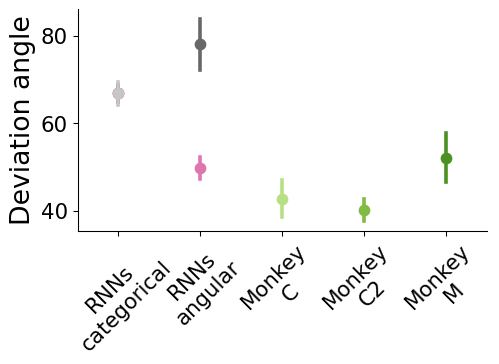

In [15]:
%matplotlib inline

# set colors
point_colors = [cm.get_cmap('PiYG')(i) for i in np.linspace(0.1,0.9,9)]
point_colors = point_colors[:2] + point_colors[-3:]
sim_sets = ['centerout_onehot', 'centerout_rad','Chewie', 'Chewie2', 'Mihili']
colors_dict = dict(zip(sim_sets, point_colors))

plt.figure(figsize = (5.5,3))
g = sns.pointplot(x="sim_set", y='dev_angle', data=deviation_angles_df[deviation_angles_df.sim_set.isin(sim_sets[:2])], order = sim_sets, palette = colors_dict)
g = sns.pointplot(x="sim_set", y='dev_angle', data=shuffled_deviation_angles_df, order = sim_sets[:2], palette = 'Greys')
g = sns.pointplot(x="sim_set", y='dev_angle', data=deviation_angles_df[deviation_angles_df.sim_set.isin(sim_sets[-3:])], order = sim_sets, palette = colors_dict)
g.set_ylabel('Deviation angle')
g.set_xlabel('')
g.set_xticklabels(['RNNs\ncategorical','RNNs\nangular','Monkey\nC', 'Monkey\nC2', 'Monkey\nM'], rotation = 45)

plt.savefig(SUBFIG_DIR + 'deviation_angle_centerout_monkey.pdf', format = 'pdf', bbox_inches="tight")

#### distances between latents

In [21]:
warnings.filterwarnings('ignore')
redo = True

fname = Constants.PROCESSED_DATA_FOLDER + 'exp' + '/'+ 'congruency_dist.pickle'

if os.path.isfile(fname) & (not redo):
    with open(fname, 'rb') as f:
        dist_df = pickle.load(f)
else:
    rows = []
    for monkey, file in tqdm(VR_files):
        datafile_name = os.path.join(exp_data_dir + monkey+ '/'+ file)

        #get and preprocess data
        exp_df = pyal.mat2dataframe(datafile_name, shift_idx_fields=True)
        exp_df = pyal.remove_low_firing_neurons(exp_df, "M1_spikes",  5)
        try:
            exp_df = pyal.remove_low_firing_neurons(exp_df, "PMd_spikes", 5)
        except:
            print(file, 'No PMd')
        skill_df = pyal.select_trials(exp_df, "epoch == 'BL'")
        skill_df = skill_df.iloc[-100:]
        skill_df = pyal.select_trials(skill_df, "result == 'R'")
        skill_df= skill_df.reset_index()
        skill_df = dt.preprocess_exp_data(skill_df, repertoires[0], subtract_mean=True, remove_low_firing = False)
        skill_df = pyal.dim_reduce(skill_df, PCA(Constants.PCA_DIMS), 'MCx_rates', 'MCx_pca')
        av_skill_df = pyal.trial_average(skill_df, "target_param")
        av_skill_df = av_skill_df.sort_values(by = 'target_param', ascending=False)
        
        data = av_skill_df.MCx_pca.values.tolist()
        n_reaches = len(data)

        #calculate distances between timesteps (for normalization)
        dist_tsteps = np.linalg.norm(np.diff(data, axis = 1),axis = 2)
        dist_m = np.zeros((n_reaches, n_reaches))

        #calculate distances between reaches
        for i in range(n_reaches):
            for j in range(i, n_reaches):
                a = data[i]
                b = data[j]
                dist_m[j][i] = np.median(np.diagonal(scipy.spatial.distance.cdist(a,b,'euclidean')))/np.median(dist_tsteps)
                dist_m[i][j] = dist_m[j][i]

        rows.append([monkey, file, dist_m])
    dist_df = pd.DataFrame(rows, columns = ['monkey', 'file', 'dist_m'])

    with open(fname, 'wb') as f:
        pickle.dump(dist_df, f)

  0%|          | 0/23 [00:00<?, ?it/s]

Chewie_CO_VR_2015-07-16.mat No PMd
Chewie_CO_VR_2013-10-03.mat No PMd
Chewie_CO_VR_2015-12-03.mat No PMd
Chewie_CO_VR_2015-12-04.mat No PMd
Chewie_CO_VR_2015-07-10.mat No PMd
Chewie_CO_VR_2013-12-19.mat No PMd
Chewie_CO_VR_2015-07-13.mat No PMd
Chewie_CO_VR_2013-12-20.mat No PMd
Chewie_CO_VR_2015-12-01.mat No PMd
Chewie_CO_VR_2015-07-15.mat No PMd
Chewie_CO_VR_2015-11-19.mat No PMd
Chewie_CO_VR_2015-07-14.mat No PMd


In [22]:
# import cosine_similarity
from sklearn.metrics.pairwise import cosine_similarity

In [23]:
#get input RDM
targets = exp_av_per_dir.target_direction.values
print(np.degrees(targets))
inputs = [[2*np.cos(t), 2*np.sin(t)] for t in targets]
unique_inputs = np.array(inputs)
input_sim = np.zeros((len(unique_inputs), len(unique_inputs)))
for i in range(len(unique_inputs)):
    for j in range(i, len(unique_inputs)):
        input_sim[j][i] = 1 - cosine_similarity(unique_inputs[i].reshape(1,-1), unique_inputs[j].reshape(1,-1))[0][0]
        input_sim[i][j] = input_sim[j][i]

# plt.figure(figsize = (4,4))
# plt.imshow(input_sim)

[   0.   45.   90.  135.  180. -135.  -90.  -45.]


In [24]:
dist_df['input_corr'] = dist_df.apply(lambda x: scipy.stats.pearsonr(input_sim[np.triu_indices(len(input_sim))], x['dist_m'][np.triu_indices(len(x['dist_m']))])[0], axis = 1)

merged_df = pd.merge(exp_decay_df, dist_df, left_on = ['sim_set', 'seed'], right_on = ['monkey', 'file'])
#remove sessions that did not fit exponential decay
merged_df = merged_df[~np.isnan(merged_df.error)]
merged_df = merged_df[(np.abs(merged_df.error) < 100)]

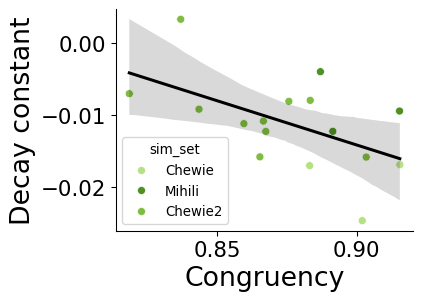

In [25]:
point_colors = [cm.get_cmap('PiYG')(i) for i in np.linspace(0.1,0.9,9)]
point_colors = point_colors[-3:]
sim_sets = ['Chewie', 'Chewie2', 'Mihili']
colors_dict = dict(zip(sim_sets, point_colors))

plt.figure(figsize=(4,3))
sns.scatterplot(data = merged_df, x = 'input_corr', y = 'decay_constant', hue = 'sim_set', palette = colors_dict)
sns.regplot(data = merged_df, x = 'input_corr', y = 'decay_constant', scatter = False, color = 'k')
plt.xlabel('Congruency')
plt.ylabel('Decay constant')

#import linregress
from scipy.stats import linregress
linregress(merged_df.input_corr, merged_df.decay_constant)

plt.savefig(SUBFIG_DIR + 'congruency_decay.pdf', bbox_inches='tight', format='pdf')
